# Work out how to deal with taxonomy

Given contigs with taxonomy and KOs of interest, wth

## Setup

In [1]:
import os 
import gc
import re
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../repo-armbrust-metat-search')

In [9]:
import functions.fn_metat_files as fnf

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [5]:
workdir = '/scratch/bgrodner/iron_ko_contigs'
os.chdir(workdir)


In [6]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [7]:
os.listdir()

['config.yaml',
 'sc_run_snakemake.sh',
 '._.DS_Store',
 'file_table.240107.kofam_filt.csv',
 'apptainer_home',
 'file_table.240109.kofam_filt.csv',
 'file_table_new.csv',
 '._file_table.240109.kofam_filt.csv',
 'file_table.test.csv',
 'jupyter_home',
 '._file_table.240107.kofam_filt.csv',
 'ko00001.json',
 '._file_table_new.csv',
 'file_table.240114.kofam_filt.csv',
 'metat_search_results',
 '._file_table.csv',
 'file_table.240113.kofam_filt.csv',
 'file_table.240107.kofam_unfilt.csv',
 '._file_table.240108.kofam_filt.csv',
 'kofam_filenames.txt',
 '.etetoolkit',
 'iron_contigs.txt',
 '.DS_Store',
 'iron_KOs.txt',
 'file_table.240108.kofam_filt.csv',
 'file_table.csv',
 '._file_table.240107.kofam_unfilt.csv',
 '._plt_KO_contig_counts.png',
 '._file_table.test.csv',
 '._file_table.240113.kofam_filt.csv',
 '._file_table.240114.kofam_filt.csv',
 '.snakemake']

Plotting

In [8]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


#### Get KO dict

Get dataframe

In [ ]:
ko_fn = "ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


In [ ]:
ld = df_kegg['Level_D'].values
ld[:5]

In [11]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

## Get taxa for ko of interest

Load taxa file

In [118]:
dir_tax = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_tax'


In [ ]:
fn = f'{dir_tax}/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-df_contig_full_taxonomy.csv'
df_tax = pd.read_csv(fn, dtype=str, keep_default_na=False)
df_tax.shape

In [ ]:
df_tax.iloc[:3,:5]

Load contig taxid dict

In [119]:
fn_dict_contig_tax = f'{dir_tax}/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-dict_contig_taxid.json'
fnf.getmem()
with open(fn_dict_contig_tax, 'r') as f:
    dict_contig_tax = json.load(f)
fnf.getmem()

Current memory usage: 4072.27 MB
Current memory usage: 4138.23 MB


get dict ko conitgs

In [120]:
dir_ko_dict = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig'
fn_dict = f'{dir_ko_dict}/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-dict.json'
fnf.getmem()
with open(fn_dict, 'r') as f:
    dict_ko_contigs = json.load(f)
fnf.getmem()

Current memory usage: 4138.24 MB
Current memory usage: 4122.24 MB


In [ ]:
df_tax['contig'][:5], dict_ko_contigs[list(dict_ko_contigs.keys())[0]][:10]

KO of interest

`KO: K14716  SLC39A10, ZIP10; solute carrier family 39 (zinc transporter), member 10`

In [118]:
ko = 'K14716'

contigs = dict_ko_contigs[ko]

list_tax_ko = []
for i, row in df_tax.iterrows():
    if row.contig in set(contigs):
        list_tax_ko.append(row.values)


In [ ]:
df_tax_ko = pd.DataFrame(np.vstack(list_tax_ko), columns=df_tax.columns)
df_tax_ko.shape

How many contigs are taxon annotated?

In [120]:
n_annotated = []
for c_vals in df_tax_ko.values[:,1:]:
    n_annotated.append(c_vals.astype(bool).sum() / 2)

In [ ]:
fig, ax = general_plot()
ax.scatter(np.arange(len(n_annotated)), np.sort(n_annotated))
xlims = ax.get_xlim()
ax.set_ylabel('Number of taxa levels annotated')
ax.set_xlabel('Contig')

Display a tree

In [123]:
ncbi = NCBITaxa()

In [ ]:
taxids = []
for c in contigs:
    t = dict_contig_tax[c][0]
    if int(t):
        try:
            ncbi.get_lineage(t)
            taxids.append(t)
        except:
            pass

tree = ncbi.get_topology(taxids)
# Add counts
tax_unq, tax_count = np.unique(taxids, return_counts=True)
dict_tax_count = dict(zip(tax_unq, tax_count))
for n in tree:
    n.add_props(count=dict_tax_count[n.name])

print(tree.to_str(props=['sci_name','count']))

In [ ]:
tree = ncbi.get_topology(taxids)

tree.descendants

KO of interest

`KO: K02639  petF; ferredoxin`


In [136]:
ko = 'K02639'

contigs = dict_ko_contigs[ko]

list_tax_ko = []
for i, row in df_tax.iterrows():
    if row.contig in set(contigs):
        list_tax_ko.append(row.values)


In [ ]:
df_tax_ko = pd.DataFrame(np.vstack(list_tax_ko), columns=df_tax.columns)
df_tax_ko.shape

How many contigs are taxon annotated?

In [138]:
n_annotated = []
for c_vals in df_tax_ko.values[:,1:]:
    n_annotated.append(c_vals.astype(bool).sum() / 2)

In [ ]:
fig, ax = general_plot()
ax.scatter(np.arange(len(n_annotated)), np.sort(n_annotated))
xlims = ax.get_xlim()
ax.set_ylabel('Number of taxa levels annotated')
ax.set_xlabel('Contig')

Display tree

In [ ]:
taxids = []
for c in contigs:
    t = dict_contig_tax[c][0]
    if int(t):
        try:
            ncbi.get_lineage(t)
            taxids.append(t)
        except:
            pass

tree = ncbi.get_topology(taxids)
# Add counts
tax_unq, tax_count = np.unique(taxids, return_counts=True)
dict_tax_count = dict(zip(tax_unq, tax_count))
for n in tree:
    n.add_props(count=dict_tax_count[n.name])

print(tree.to_str(props=['sci_name','count'], compact=True))

KO of interest

`KO: K01624  FBA, fbaA; fructose-bisphosphate aldolase, class II [EC:4.1.2.13]`

In [167]:
ko = 'K01624'

contigs = dict_ko_contigs[ko]

In [142]:


list_tax_ko = []
for i, row in df_tax.iterrows():
    if row.contig in set(contigs):
        list_tax_ko.append(row.values)


In [ ]:
df_tax_ko = pd.DataFrame(np.vstack(list_tax_ko), columns=df_tax.columns)
df_tax_ko.shape

How many contigs are taxon annotated?

In [144]:
n_annotated = []
for c_vals in df_tax_ko.values[:,1:]:
    n_annotated.append(c_vals.astype(bool).sum() / 2)

In [ ]:
fig, ax = general_plot()
ax.scatter(np.arange(len(n_annotated)), np.sort(n_annotated))
xlims = ax.get_xlim()
ax.set_ylabel('Number of taxa levels annotated')
ax.set_xlabel('Contig')

Display tree

In [ ]:
# Get taxids for KO
taxids = []
for c in contigs:
    t = dict_contig_tax[c][0]
    if int(t):
        try:
            ncbi.get_lineage(t)
            taxids.append(t)
        except:
            pass
# Build tree
tree = ncbi.get_topology(taxids)
# Add counts at each internal node
lineages = [ncbi.get_lineage(t) for t in taxids]
taxids_lin = list(itertools.chain(*lineages))
tax_unq, tax_count = np.unique(taxids_lin, return_counts=True)
dict_tax_count = dict(zip(tax_unq, tax_count))
for n in tree.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_count[tax])

print(tree.to_str(props=['sci_name','count'], compact=True))

KO of interest

`KO: K03320  amt, AMT, MEP; ammonium transporter, Amt family`

In [164]:
ko = 'K03320'

contigs = dict_ko_contigs[ko]

Get taxon lineage table

In [147]:

list_tax_ko = []
for i, row in df_tax.iterrows():
    if row.contig in set(contigs):
        list_tax_ko.append(row.values)


In [ ]:
df_tax_ko = pd.DataFrame(np.vstack(list_tax_ko), columns=df_tax.columns)
df_tax_ko.shape

How many contigs are taxon annotated?

In [149]:
n_annotated = []
for c_vals in df_tax_ko.values[:,1:]:
    n_annotated.append(c_vals.astype(bool).sum() / 2)

In [ ]:
fig, ax = general_plot()
ax.scatter(np.arange(len(n_annotated)), np.sort(n_annotated))
xlims = ax.get_xlim()
ax.set_ylabel('Number of taxa levels annotated')
ax.set_xlabel('Contig')

Display tree

In [ ]:
# Get taxids for KO
taxids = []
for c in contigs:
    t = dict_contig_tax[c][0]
    if int(t):
        try:
            ncbi.get_lineage(t)
            taxids.append(t)
        except:
            pass
# Build tree
tree = ncbi.get_topology(taxids)
# Add counts at each internal node
lineages = [ncbi.get_lineage(t) for t in taxids]
taxids_lin = list(itertools.chain(*lineages))
tax_unq, tax_count = np.unique(taxids_lin, return_counts=True)
dict_tax_count = dict(zip(tax_unq, tax_count))
for n in tree.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_count[tax])

print(tree.to_str(props=['sci_name','count'], compact=True))

## Pick taxonomic levels with counts across multiple samples

Get full taxonomic tree

In [139]:
# full tax list
taxids_all = []
for t in dict_contig_tax.values():
    t = t[0]
    if int(t):
        try:
            ncbi.get_lineage(t)
            taxids_all.append(t)
        except:
            pass

set_taxids = set(taxids_all)
len(set_taxids)

745

In [ ]:
tree = ncbi.get_topology(set_taxids)
print(tree.to_str(props=['name', 'sci_name'], compact=True))

Get dict taxid -> contig list (for full lineage)

In [140]:
dict_tax_contigs = defaultdict(list)
for c, t in dict_contig_tax.items():
    if t[0] in set_taxids:
        lin = ncbi.get_lineage(t[0])
        for l in lin:
            dict_tax_contigs[l].append(c)

Get dict contig -> KO

In [133]:
dict_contig_ko = {}
for ko, contigs in dict_ko_contigs.items():
    for c in contigs:
        dict_contig_ko[c] = ko

### Pick an example leaf

In [304]:
leaf = 637379  # T. oceanica


For a given taxid, get number of different KOs

In [ ]:
contigs = dict_tax_contigs[leaf]
kos = [dict_contig_ko[c] for c in contigs]
set_kos = set(kos)
set_kos, len(contigs), len(set(contigs))

Get dict contig -> sample counts

In [306]:
# Get list of sample names
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)
dict_contig_counts = defaultdict(list)
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        for c in contigs:
            c_ = re.sub(r'_\d+$','',c)
            # map contig to counts
            dict_contig_counts[c].append(dict_ctg_cnt[c_])

Build out dataframe

In [ ]:
df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
for c in contigs:
    ko = dict_contig_ko[c]
    df_taxid[ko] += np.array(dict_contig_counts[c])

df_taxid

In [ ]:
set(dict_ko_contigs['K01726']).intersection(set(contigs))

### Walk up through the lineage of the leaf

In [ ]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)
dfs = {}
# Get leaf
print(leaf)
# Kos and contigs
contigs = dict_tax_contigs[leaf]
kos = [dict_contig_ko[c] for c in contigs]
set_kos = set(kos)
# Dict contig -> sample counts
dict_contig_counts = defaultdict(list)
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        for c in contigs:
            c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
            # map contig to counts
            dict_contig_counts[c].append(dict_ctg_cnt[c_])
# Build out dataframe
df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
for c in contigs:
    ko = dict_contig_ko[c]
    df_taxid[ko] += np.array(dict_contig_counts[c])
dfs[leaf] = (df_taxid)
# Get ancestors of leaf
for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < 6:
        print(n.name)
        # Kos and contigs
        contigs = dict_tax_contigs[int(n.name)]
        kos = [dict_contig_ko[c] for c in contigs]
        set_kos = set(kos)
        # Dict contig -> sample counts
        dict_contig_counts = defaultdict(list)
        samples = []
        for fn in fns:
            if '_3um' in fn:
                samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
                # Load counts
                df = pd.read_csv(fn)
                ctg = df.iloc[:,0].values
                cnt = df.iloc[:,1].values
                dict_ctg_cnt = dict(zip(ctg, cnt))
                for c in contigs:
                    c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                    # map contig to counts
                    dict_contig_counts[c].append(dict_ctg_cnt[c_])
        # Build out dataframe
        df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
        for c in contigs:
            ko = dict_contig_ko[c]
            df_taxid[ko] += np.array(dict_contig_counts[c])
        dfs[n.name] = (df_taxid)

Inspect dataframes

In [ ]:
df_taxid = dfs[637379]
print(df_taxid.shape)
df_taxid

Inspect dataframes

In [ ]:
df_taxid = dfs['35127']
print(df_taxid.shape)
df_taxid

In [ ]:
df_taxid = dfs['29202']
print(df_taxid.shape)
df_taxid

In [ ]:
df_taxid = dfs['33847']
print(df_taxid.shape)
df_taxid

In [ ]:
df_taxid = dfs['33846']
print(df_taxid.shape)
df_taxid

In [ ]:
df_taxid = dfs['33836']
print(df_taxid.shape)
df_taxid

In [ ]:
df_taxid = dfs['2836']
print(df_taxid.shape)
df_taxid

Get info on count matrices

In [ ]:
sci_names = []
n_ko = []
frac_sam_filled = []

df = dfs[leaf]
scn = ncbi.get_rank([leaf])[leaf] + ' ' + ncbi.get_taxid_translator([str(leaf)])[leaf]
sci_names.append(scn)
n_ko.append(df.shape[1])
fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
frac_sam_filled.append(fracs)

for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < 6:
        tid = n.name
        df = dfs[tid]
        scn = ncbi.get_rank([tid])[int(tid)] + ' ' + ncbi.get_taxid_translator([str(tid)])[int(tid)]
        sci_names.append(scn)
        n_ko.append(df.shape[1])
        fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
        frac_sam_filled.append(fracs)

In [ ]:
ncbi.get_taxid_translator([str(leaf)])[leaf]


Plot number of kos

In [ ]:
ft=8
dims=(4,4)
fig, ax = general_plot(ft=ft, dims=dims)
x = np.arange(len(n_ko))
ax.plot(x, n_ko)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Number of KOs')

Plot fraction of samples with counts in each KO

In [ ]:
ft=8
dims=(4,4)
markersize=2
fig, ax = general_plot(ft=ft, dims=dims)
ax.boxplot(frac_sam_filled)
for _x, fsf in enumerate(frac_sam_filled):
    _x += (np.random.rand(len(fsf)) - 0.5) * 0.25 + 1
    ax.scatter(_x, fsf, s=markersize, c='k')
x = np.arange(len(n_ko)) + 1
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Fraction of samples\nwith counts for each KO')

#### Check another leaf

In [319]:
leaf = 2802065 #,Chrysochromulina sp. KB-HA01

In [ ]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)
dfs = {}
# Get leaf
print(leaf)
# Kos and contigs
contigs = dict_tax_contigs[leaf]
kos = [dict_contig_ko[c] for c in contigs]
set_kos = set(kos)
# Dict contig -> sample counts
dict_contig_counts = defaultdict(list)
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        for c in contigs:
            c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
            # map contig to counts
            dict_contig_counts[c].append(dict_ctg_cnt[c_])
# Build out dataframe
df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
for c in contigs:
    ko = dict_contig_ko[c]
    df_taxid[ko] += np.array(dict_contig_counts[c])
dfs[leaf] = (df_taxid)
# Get ancestors of leaf
for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < 100:
        print(n.name)
        # Kos and contigs
        contigs = dict_tax_contigs[int(n.name)]
        kos = [dict_contig_ko[c] for c in contigs]
        set_kos = set(kos)
        # Dict contig -> sample counts
        dict_contig_counts = defaultdict(list)
        samples = []
        for fn in fns:
            if '_3um' in fn:
                samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
                # Load counts
                df = pd.read_csv(fn)
                ctg = df.iloc[:,0].values
                cnt = df.iloc[:,1].values
                dict_ctg_cnt = dict(zip(ctg, cnt))
                for c in contigs:
                    c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                    # map contig to counts
                    dict_contig_counts[c].append(dict_ctg_cnt[c_])
        # Build out dataframe
        df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
        for c in contigs:
            ko = dict_contig_ko[c]
            df_taxid[ko] += np.array(dict_contig_counts[c])
        dfs[n.name] = (df_taxid)

Get info on count matrices

In [324]:
sci_names = []
n_ko = []
frac_sam_filled = []

df = dfs[leaf]
scn = ncbi.get_rank([leaf])[leaf] + ' ' + ncbi.get_taxid_translator([str(leaf)])[leaf]
sci_names.append(scn)
n_ko.append(df.shape[1])
fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
frac_sam_filled.append(fracs)

for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < 6:
        tid = n.name
        df = dfs[tid]
        scn = ncbi.get_rank([tid])[int(tid)] + ' ' + ncbi.get_taxid_translator([str(tid)])[int(tid)]
        sci_names.append(scn)
        n_ko.append(df.shape[1])
        fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
        frac_sam_filled.append(fracs)

In [ ]:
ncbi.get_taxid_translator([str(leaf)])[leaf]


Plot number of kos

In [ ]:
ft=8
dims=(4,4)
fig, ax = general_plot(ft=ft, dims=dims)
x = np.arange(len(n_ko))
ax.plot(x, n_ko)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Number of KOs')

Plot fraction of samples with counts in each KO

In [ ]:
ft=8
dims=(4,4)
markersize=2
fig, ax = general_plot(ft=ft, dims=dims)
ax.boxplot(frac_sam_filled)
for _x, fsf in enumerate(frac_sam_filled):
    _x += (np.random.rand(len(fsf)) - 0.5) * 0.25 + 1
    ax.scatter(_x, fsf, s=markersize, c='k')
x = np.arange(len(n_ko)) + 1
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Fraction of samples\nwith counts for each KO')

#### Check another leaf

In [328]:
leaf = 413974 #,Chlamydomonas sp. CCMP681
n_level = 6

In [ ]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)
dfs = {}
# Get leaf
print(leaf)
# Kos and contigs
contigs = dict_tax_contigs[leaf]
kos = [dict_contig_ko[c] for c in contigs]
set_kos = set(kos)
# Dict contig -> sample counts
dict_contig_counts = defaultdict(list)
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        for c in contigs:
            c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
            # map contig to counts
            dict_contig_counts[c].append(dict_ctg_cnt[c_])
# Build out dataframe
df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
for c in contigs:
    ko = dict_contig_ko[c]
    df_taxid[ko] += np.array(dict_contig_counts[c])
dfs[leaf] = (df_taxid)
# Get ancestors of leaf
for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < n_level:
        print(n.name)
        # Kos and contigs
        contigs = dict_tax_contigs[int(n.name)]
        kos = [dict_contig_ko[c] for c in contigs]
        set_kos = set(kos)
        # Dict contig -> sample counts
        dict_contig_counts = defaultdict(list)
        samples = []
        for fn in fns:
            if '_3um' in fn:
                samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
                # Load counts
                df = pd.read_csv(fn)
                ctg = df.iloc[:,0].values
                cnt = df.iloc[:,1].values
                dict_ctg_cnt = dict(zip(ctg, cnt))
                for c in contigs:
                    c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                    # map contig to counts
                    dict_contig_counts[c].append(dict_ctg_cnt[c_])
        # Build out dataframe
        df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
        for c in contigs:
            ko = dict_contig_ko[c]
            df_taxid[ko] += np.array(dict_contig_counts[c])
        dfs[n.name] = (df_taxid)

Get info on count matrices

In [333]:
sci_names = []
n_ko = []
frac_sam_filled = []

df = dfs[leaf]
scn = ncbi.get_rank([leaf])[leaf] + ' ' + ncbi.get_taxid_translator([str(leaf)])[leaf]
sci_names.append(scn)
n_ko.append(df.shape[1])
fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
frac_sam_filled.append(fracs)

for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < n_level:
        tid = n.name
        df = dfs[n.name]
        scn = ncbi.get_rank([tid])[int(tid)] + ' ' + ncbi.get_taxid_translator([str(tid)])[int(tid)]
        sci_names.append(scn)
        n_ko.append(df.shape[1])
        fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
        frac_sam_filled.append(fracs)

In [ ]:
ncbi.get_taxid_translator([str(leaf)])[leaf]


Plot number of kos

In [ ]:
ft=8
dims=(4,4)
fig, ax = general_plot(ft=ft, dims=dims)
x = np.arange(len(n_ko))
ax.plot(x, n_ko)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Number of KOs')

Plot fraction of samples with counts in each KO

In [ ]:
ft=8
dims=(4,4)
markersize=2
fig, ax = general_plot(ft=ft, dims=dims)
ax.boxplot(frac_sam_filled)
for _x, fsf in enumerate(frac_sam_filled):
    _x += (np.random.rand(len(fsf)) - 0.5) * 0.25 + 1
    ax.scatter(_x, fsf, s=markersize, c='k')
x = np.arange(len(n_ko)) + 1
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Fraction of samples\nwith counts for each KO')

#### Check another leaf

In [337]:
leaf = 174948 # Symbiodinium sp. CCMP421
n_level = 6

In [ ]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)
dfs = {}
# Get leaf
print(leaf)
# Kos and contigs
contigs = dict_tax_contigs[leaf]
kos = [dict_contig_ko[c] for c in contigs]
set_kos = set(kos)
# Dict contig -> sample counts
dict_contig_counts = defaultdict(list)
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        for c in contigs:
            c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
            # map contig to counts
            dict_contig_counts[c].append(dict_ctg_cnt[c_])
# Build out dataframe
df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
for c in contigs:
    ko = dict_contig_ko[c]
    df_taxid[ko] += np.array(dict_contig_counts[c])
dfs[leaf] = (df_taxid)
# Get ancestors of leaf
for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < n_level:
        print(n.name)
        # Kos and contigs
        contigs = dict_tax_contigs[int(n.name)]
        kos = [dict_contig_ko[c] for c in contigs]
        set_kos = set(kos)
        # Dict contig -> sample counts
        dict_contig_counts = defaultdict(list)
        samples = []
        for fn in fns:
            if '_3um' in fn:
                samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
                # Load counts
                df = pd.read_csv(fn)
                ctg = df.iloc[:,0].values
                cnt = df.iloc[:,1].values
                dict_ctg_cnt = dict(zip(ctg, cnt))
                for c in contigs:
                    c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                    # map contig to counts
                    dict_contig_counts[c].append(dict_ctg_cnt[c_])
        # Build out dataframe
        df_taxid = pd.DataFrame(0, columns=list(set_kos), index=samples)
        for c in contigs:
            ko = dict_contig_ko[c]
            df_taxid[ko] += np.array(dict_contig_counts[c])
        dfs[n.name] = (df_taxid)

Get info on count matrices

In [342]:
sci_names = []
n_ko = []
frac_sam_filled = []

df = dfs[leaf]
scn = ncbi.get_rank([leaf])[leaf] + ' ' + ncbi.get_taxid_translator([str(leaf)])[leaf]
sci_names.append(scn)
n_ko.append(df.shape[1])
fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
frac_sam_filled.append(fracs)

for i, n in enumerate(tree[str(leaf)].ancestors()):
    if i < n_level:
        df = dfs[n.name]
        tid = n.name
        scn = ncbi.get_rank([tid])[int(tid)] + ' ' + ncbi.get_taxid_translator([str(tid)])[int(tid)]
        sci_names.append(scn)
        n_ko.append(df.shape[1])
        fracs = df.values.astype(bool).sum(axis=0) / df.shape[0]
        frac_sam_filled.append(fracs)

In [ ]:
ncbi.get_taxid_translator([str(leaf)])[leaf]


Plot number of kos

In [ ]:
ft=8
dims=(4,4)
fig, ax = general_plot(ft=ft, dims=dims)
x = np.arange(len(n_ko))
ax.plot(x, n_ko)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Number of KOs')

Plot fraction of samples with counts in each KO

In [ ]:
ft=8
dims=(4,4)
markersize=2
fig, ax = general_plot(ft=ft, dims=dims)
ax.boxplot(frac_sam_filled)
for _x, fsf in enumerate(frac_sam_filled):
    _x += (np.random.rand(len(fsf)) - 0.5) * 0.25 + 1
    ax.scatter(_x, fsf, s=markersize, c='k')
x = np.arange(len(n_ko)) + 1
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(sci_names, rotation=45, ha='right', rotation_mode='anchor')
_ = ax.set_ylabel('Fraction of samples\nwith counts for each KO')

## 

## Write code for full tree based on KO count and frac sample filters

Get number of leafs

In [ ]:
len(list(tree.leaf_names())), len(list(tree.descendants()))

Verify that internal nodes are nort in leafs

In [ ]:
# Alveolata clade
('33630' in list(tree.leaf_names())), ('33630' in [n.name for n in tree.descendants()])

Write snakeamke rule to trim leaf

In [372]:
leaf = 2802065 #,Chrysochromulina sp. KB-HA01

thresh_n_kos = 20
thresh_mff = 0.2

dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)

lineage = [str(leaf)] + [n.name for n in tree[str(leaf)].ancestors()]
dict_lin_nkos = {}
dict_lin_ko_cnts = defaultdict(lambda: defaultdict(list))
# Load dict_tax_contigs, dict_contig_ko

# Get number of kos for each lineage
for l in lineage:
    contigs = dict_tax_contigs[int(l)]
    kos = [dict_contig_ko[c] for c in contigs]
    # add number of kos to lineage info
    set_kos = set(kos)
    dict_lin_nkos[l] = len(set_kos)

# Get KO counts for each sample
for fn in fns:
    if '_3um' in fn:
        # Load dict_contig_count
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        # Count each lineage
        # n_kos = 0
        # mean_frac_fill = 0
        for l in lineage:
            # if (n_kos < thresh_n_kos) or (mean_frac_fill < thresh_mff):
            contigs = dict_tax_contigs[int(l)]
            # counts and kos
            dict_ko_cnt = defaultdict(lambda: 0)
            for c in contigs:
                ko = dict_contig_ko[c]
                c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                dict_ko_cnt[ko] += dict_ctg_cnt[c_]
            # Add ko count to lineage info
            for ko, cnt in dict_ko_cnt.items():
                dict_lin_ko_cnts[l][ko].append(cnt)





In [ ]:
for l in lineage:
    print('\n',l)
    print(dict_lin_nkos[l])
    frac_kos = []
    for ko, counts in dict_lin_ko_cnts[l].items():
        frac = np.array(counts).astype(bool).sum()
        frac_kos.append(frac)
    print(np.mean(frac_kos))

In [ ]:
y.shape

In [ ]:
taxid = 236786  # Florenciella

contigs = dict_tax_contigs[taxid]
kos = set(dict_contig_ko[c] for c in contigs)
ko_names = [dict_ko_name[k] for k in kos]
ko_names

## Look at the fraction of contigs captured by a set of leaves 

Get counts for each node

In [ ]:
# rank = ncbi.get_rank([n.name])[n.name]

# Add counts at each internal node
lineages = [ncbi.get_lineage(t) for t in taxids_all]
taxids_lin = list(itertools.chain(*lineages))
tax_unq, tax_count = np.unique(taxids_lin, return_counts=True)
dict_tax_contigcount = dict(zip(tax_unq, tax_count))
for n in tree.traverse():
    tax = int(n.name)
    n.add_props(n_contigs=dict_tax_contigcount[tax])

Get total number of contigs

In [ ]:
n_contigs = len(taxids_all)
n_contigs

 Get fraction with max leaves


In [ ]:
c_count = 0
for n in tree.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs
frac

Get fraction trimmed to genus level

In [ ]:
tree_genus = ncbi.get_topology(set_taxids, rank_limit='genus')

# Add contig counts
for n in tree_genus.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_contigcount[tax])

c_count = 0
for n in tree_genus.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs
frac

Get fraction trimmed to family level

In [ ]:
tree_fam = ncbi.get_topology(set_taxids, rank_limit='family')

# Add contig counts
for n in tree_fam.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_contigcount[tax])

c_count = 0
for n in tree_fam.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs
frac

Get fraction trimmed to order level

In [ ]:
tree_ord = ncbi.get_topology(set_taxids, rank_limit='order')

# Add contig counts
for n in tree_ord.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_contigcount[tax])

c_count = 0
for n in tree_ord.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs
frac

Get fraction trimmed to class level

In [ ]:
tree_class = ncbi.get_topology(set_taxids, rank_limit='class')

# Add contig counts
for n in tree_class.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_contigcount[tax])

c_count = 0
for n in tree_class.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs
frac

Get fraction trimmed to phylum level (seems like trimming is not working properly since not all taxa have phylum annotation)

In [ ]:
tree_phy = ncbi.get_topology(set_taxids, rank_limit='phylum')

# Add contig counts
for n in tree_phy.traverse():
    tax = int(n.name)
    n.add_props(count=dict_tax_contigcount[tax])

c_count = 0
for n in tree_phy.leaves():
    c_count += n.props['count']

frac = c_count / n_contigs

print(frac)
print(tree_phy.to_str(props=['name', 'sci_name'], compact=True))

## Get mean number of samples filled across KOs for full tree

Get values for each node in tree

In [ ]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tables_norm_count'
glob_fn = f'{dir_counts}/*.tsv-table_norm_count.csv'
fns = glob.glob(glob_fn)

# lineage = [str(leaf)] + [n.name for n in tree[str(leaf)].ancestors()]
dict_lin_nkos = {}
dict_lin_ko_cnts = defaultdict(lambda: defaultdict(list))
# Load dict_tax_contigs, dict_contig_ko

# Get number of kos for each lineage
for n in tree.traverse():
    l = n.name
    contigs = dict_tax_contigs[int(l)]
    kos = [dict_contig_ko[c] for c in contigs]
    # add number of kos to lineage info
    set_kos = set(kos)
    dict_lin_nkos[l] = len(set_kos)

# Get KO counts for each sample
for fn in tqdm(fns):
    if '_3um' in fn:
        # Load dict_contig_count
        df = pd.read_csv(fn)
        ctg = df.iloc[:,0].values
        cnt = df.iloc[:,1].values
        dict_ctg_cnt = dict(zip(ctg, cnt))
        # Count each lineage
        # n_kos = 0
        # mean_frac_fill = 0
        for n in tree.traverse():
            l = n.name
            # if (n_kos < thresh_n_kos) or (mean_frac_fill < thresh_mff):
            contigs = dict_tax_contigs[int(l)]
            # counts and kos
            dict_ko_cnt = defaultdict(lambda: 0)
            for c in contigs:
                ko = dict_contig_ko[c]
                c_ = re.sub(r'_\d+$','',c)  # manage 6tr filenaming
                dict_ko_cnt[ko] += dict_ctg_cnt[c_]
            # Add ko count to lineage info
            for ko, cnt in dict_ko_cnt.items():
                dict_lin_ko_cnts[l][ko].append(cnt)





Get dict mapping taxid in tree to max and mean n samples across kos

In [478]:
dict_lin_maxmeannsam = {}
for n in tree.traverse():
    l = n.name
    n_sam = []
    for ko, counts in dict_lin_ko_cnts[l].items():
        ns = np.array(counts).astype(bool).sum()
        n_sam.append(ns)
    max_n_sam = np.max(n_sam)
    mean_n_sam = np.round(np.mean(n_sam), 1)
    dict_lin_maxmeannsam[l] = [max_n_sam, mean_n_sam]

Plot tree with n contigs, n kos, and max sample counts across kos

In [ ]:
for n in tree.traverse():
    l = n.name
    n_contigs = dict_tax_contigcount[int(l)]
    max_n_sam, meam_n_sam = dict_lin_maxmeannsam[l]
    nkos = dict_lin_nkos[l]
    n.add_props(
        n_contigs=n_contigs, 
        max_n_sam=max_n_sam, 
        mean_n_sam=mean_n_sam, 
        nkos=nkos
    )

In [ ]:
print(tree.to_str(props=['sci_name','n_contigs','nkos','max_n_sam'], compact=True))

In [ ]:
print(tree.to_str(props=['sci_name','n_contigs','name'], compact=True))

Look at distributions of n contigs

In [ ]:
c_counts = []
for n in tree.traverse():
    l = int(n.name)
    c_counts.append(dict_tax_contigcount[l])


fig, ax = general_plot()
_ = ax.hist(np.log(c_counts), bins=100)
xlims = ax.get_xlim()
xticks = np.arange(int(max(xlims)))
_ = ax.set_xticks(xticks)
xlab = [f'1e{l}' for l in xticks]
_ = ax.set_xticklabels(xlab, fontsize=8)
_ = ax.set_xlabel('Number of contigs in taxid')
# ax.set_xscale('log')

Look at distributions of n kos

In [ ]:
c_counts = []
for n in tree.traverse():
    l = n.name
    c_counts.append(dict_lin_nkos[l])


fig, ax = general_plot()
bins = np.arange(0,max(np.log(c_counts)),0.1)
_ = ax.hist(np.log(c_counts), bins=bins)
xlims = ax.get_xlim()
xticks = np.arange(int(max(xlims)))
_ = ax.set_xticks(xticks)
xlab = [f'1e{l}' for l in xticks]
_ = ax.set_xticklabels(xlab, fontsize=8)
_ = ax.set_xlabel('Number of KOs in taxid')
# ax.set_xscale('log')

Look at distributions of max samples across kos

In [ ]:
c_counts = []
for n in tree.traverse():
    l = n.name
    c_counts.append(dict_lin_maxmeannsam[l][0])


fig, ax = general_plot(ft=8)
bins = np.arange(0,max(c_counts),1)
_ = ax.hist(c_counts, bins=bins)
xlims = ax.get_xlim()
xticks = np.arange(int(max(xlims)))
_ = ax.set_xticks(xticks)
# xlab = [f'1e{l}' for l in xticks]
# _ = ax.set_xticklabels(xlab, fontsize=8)
# _ = ax.set_xticklabels(fontsize=8)
_ = ax.set_xlabel('Max number of samples with nonzero counts across KOs in taxid')
# ax.set_xscale('log')

Look at distributions of mean samples across kos

In [ ]:
c_counts = []
for n in tree.traverse():
    l = n.name
    c_counts.append(dict_lin_maxmeannsam[l][1])


fig, ax = general_plot(ft=8)
bins = np.arange(0,max(c_counts),1)
_ = ax.hist(c_counts, bins=bins)
xlims = ax.get_xlim()
xticks = np.arange(int(max(xlims)))
_ = ax.set_xticks(xticks)
# xlab = [f'1e{l}' for l in xticks]
# _ = ax.set_xticklabels(xlab, fontsize=8)
# _ = ax.set_xticklabels(fontsize=8)
_ = ax.set_xlabel('Mean number of samples with nonzero counts across KOs in taxid')
# ax.set_xscale('log')

Plot n contigs vs nkos

In [ ]:
k_counts = []
c_counts = []
for n in tree.traverse():
    c_counts.append(n.props['n_contigs'])
    k_counts.append(n.props['nkos'])

fig, ax = general_plot()
ax.scatter(k_counts, c_counts, alpha=0.25)
_ = ax.set_xlabel('Number of KOs')
_ = ax.set_ylabel('Number of contigs')
_ = ax.set_yscale('log')
_ = ax.set_xscale('log')

## Trim leaves based on loose filters

Trim taxids

In [534]:
thresh_n_contigs = 30
thresh_nkos = 30

taxids_trim = []
for n in tree.leaves():
    nc = n.props['n_contigs']
    nk = n.props['nkos']
    tid = n.name
    ancest = n.ancestors()
    while (nc < thresh_n_contigs) or (nk < thresh_nkos):
        n_a = next(ancest)
        nc = n_a.props['n_contigs']
        nk = n_a.props['nkos']
        tid = n_a.name            
    taxids_trim.append(tid)


Annotate props

In [535]:
tree_trim = ncbi.get_topology(taxids_trim)

for n in tree_trim.traverse():
    l = n.name
    n_contigs = dict_tax_contigcount[int(l)]
    max_n_sam, meam_n_sam = dict_lin_maxmeannsam[l]
    nkos = dict_lin_nkos[l]
    n.add_props(
        n_contigs=n_contigs, 
        max_n_sam=max_n_sam, 
        mean_n_sam=mean_n_sam, 
        nkos=nkos
    )

Plot

In [ ]:
print(tree_trim.to_str(props=['sci_name','n_contigs','nkos','max_n_sam'], compact=True))

Fraction of contigs with these leaves

In [ ]:
c_count = 0
for n in tree_trim.leaves():
    c_count += n.props['n_contigs']

total_n_contigs = len(taxids_all)

frac = c_count / total_n_contigs
c_count, frac

At each node, what is the fraction of contigs with this as their finest rank?

In [538]:
for n in tree_trim.traverse():
    nc_current = n.props['n_contigs']
    nc_descend = 0
    for n_d in n.get_children():
        nc_descend += n_d.props['n_contigs']
    n.add_props(
        frac_finest = round(1 - nc_descend / nc_current, 2)
    )

In [ ]:
print(tree_trim.to_str(props=['sci_name','n_contigs', 'frac_finest'], compact=True))

How many taxids do I have?

In [ ]:
n_taxids_trim = len(list(tree_trim.traverse()))
n_taxids_trim

Assign trimmed taxonomy to contigs

In [ ]:
# Get the full set of taxids in the trimmmed tree
set_taxids_trim = set(n.name for n in tree_trim.traverse())

# Set up a new taxon mapping
dict_contig_taxtrim = {}
for c, t in dict_contig_tax.items():
    t = t[0]
    if int(t):
        # If there's no need to trim this taxid
        if t in set_taxids_trim:
            dict_contig_taxtrim[c] = t
        else:
            # If the taxid exists in the ncbi database
            try:
                ancest = iter([str(l) for l in  ncbi.get_lineage(t)][::-1])
                too_low = 1
                # Step back through ancestors
                while too_low:
                    ta = next(ancest)
                    if ta in set_taxids_trim:
                        dict_contig_taxtrim[c] = ta
                        too_low = 0
            except:
                pass



## Trim leaves based on strict filters

Trim taxids

In [542]:
thresh_n_contigs = 30
thresh_nkos = 90

taxids_trim = []
for n in tree.leaves():
    nc = n.props['n_contigs']
    nk = n.props['nkos']
    tid = n.name
    ancest = n.ancestors()
    while (nc < thresh_n_contigs) or (nk < thresh_nkos):
        n_a = next(ancest)
        nc = n_a.props['n_contigs']
        nk = n_a.props['nkos']
        tid = n_a.name            
    taxids_trim.append(tid)


Annotate props

In [543]:
tree_trim = ncbi.get_topology(taxids_trim)

for n in tree_trim.traverse():
    l = n.name
    n_contigs = dict_tax_contigcount[int(l)]
    max_n_sam, meam_n_sam = dict_lin_maxmeannsam[l]
    nkos = dict_lin_nkos[l]
    n.add_props(
        n_contigs=n_contigs, 
        max_n_sam=max_n_sam, 
        mean_n_sam=mean_n_sam, 
        nkos=nkos
    )

Plot

In [ ]:
print(tree_trim.to_str(props=['sci_name','n_contigs','nkos','max_n_sam'], compact=True))

In [ ]:
tree

Fraction of contigs with these leaves

In [ ]:
c_count = 0
for n in tree_trim.leaves():
    c_count += n.props['n_contigs']

total_n_contigs = len(taxids_all)

frac = c_count / total_n_contigs
c_count, frac

At each node, what is the fraction of contigs with this as their finest rank?

In [546]:
for n in tree_trim.traverse():
    nc_current = n.props['n_contigs']
    nc_descend = 0
    for n_d in n.get_children():
        nc_descend += n_d.props['n_contigs']
    n.add_props(
        frac_finest = round(1 - nc_descend / nc_current, 2)
    )

In [ ]:
print(tree_trim.to_str(props=['sci_name','n_contigs', 'frac_finest'], compact=True))

How many taxids do I have?

In [ ]:
n_taxids_trim = len(list(tree_trim.traverse()))
n_taxids_trim

Assign trimmed taxonomy to contigs

In [549]:
# Get the full set of taxids in the trimmmed tree
set_taxids_trim = set(n.name for n in tree_trim.traverse())

# Set up a new taxon mapping
dict_contig_taxtrim = {}
for c, t in dict_contig_tax.items():
    t = t[0]
    if int(t):
        # If there's no need to trim this taxid
        if t in set_taxids_trim:
            dict_contig_taxtrim[c] = t
        else:
            # If the taxid exists in the ncbi database
            try:
                ancest = iter([str(l) for l in  ncbi.get_lineage(t)][::-1])
                too_low = 1
                # Step back through ancestors
                while too_low:
                    ta = next(ancest)
                    if ta in set_taxids_trim:
                        dict_contig_taxtrim[c] = ta
                        too_low = 0
            except:
                pass



Map node name to contig list (contigs that don't map to a lower node)

In [ ]:
dict_taxtrim_contigs = defaultdict(list)
for c, t in dict_contig_taxtrim.items():
    dict_taxtrim_contigs[t].append(c)

Get nkos at each node (not including children)

In [607]:
for n in tree_trim.traverse():
    contigs = dict_taxtrim_contigs[n.name]
    kos = [dict_contig_ko[c] for c in contigs]
    n.add_props(
        nkos_nochild=len(set(kos))
    )


In [ ]:
print(tree_trim.to_str(props=['sci_name','nkos_nochild'], compact=True))

## Build slabs

Get dict contig -> sample est counts

In [14]:
# Get list of sample names
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count'
glob_fn = f'{dir_counts}/*G1PA*3um*.json'
fns = glob.glob(glob_fn)
fns


['/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-G1PA.kallisto_abundance.tar.gz.G1PA.S09C1_3umB.abundance.tsv-dict.json',
 '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-G1PA.kallisto_abundance.tar.gz.G1PA.S08C1_3umA.abundance.tsv-dict.json',
 '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-G1PA.kallisto_abundance.tar.gz.G1PA.S04C1_3umA.abundance.tsv-dict.json',
 '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-G1PA.kallisto_abundance.tar.gz.G1PA.S11C1_3umB.abundance.tsv-dict.json',
 '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_c

In [121]:
fnf.getmem()
dict_contig_estcounts = defaultdict(list)
contigs_all = list(dict_contig_tax.keys())
samples = []
for fn in fns:
    if '_3um' in fn:
        samples.append(re.search(r'(?<=.tar.gz).+(?=\.tsv-)', fn)[0])
        # Load counts
        with open(fn, 'r') as f:
            dict_ctg_cnt = json.load(f)
        for c in contigs_all:
            c_ = re.sub(r'_\d+$','',c)
            # map contig to counts
            dict_contig_estcounts[c].append(float(dict_ctg_cnt[c_][0]))
fnf.getmem()


Current memory usage: 4122.24 MB
Current memory usage: 4090.85 MB


In [ ]:
[[c, dict_contig_estcounts[c]] for c in contigs_all[:10]]

How many kos are in each sample across the nodes?

In [574]:
dict_tax_sam_kos = defaultdict(lambda: defaultdict(set))
for n in tree_trim.traverse():
    contigs = dict_taxtrim_contigs[n.name]
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        for sam, ec in enumerate(estcounts):
            if ec:
                dict_tax_sam_kos[n.name][sam].add(ko)

In [ ]:
fig, ax = general_plot(dims=(10,4))

xlab = []

for x_, n in enumerate(tree_trim.traverse()):
    nkos = []
    for _, kos in dict_tax_sam_kos[n.name].items():
        nkos.append(len(kos))
    x = np.repeat(x_, len(nkos)).astype(float) 
    x += (np.random.rand(x.shape[0]) - 0.5) * 0.25
    ax.scatter(x, np.array(nkos), c='k', s=2)
    xlab.append(n.props['sci_name'])

ax.set_xticks(np.arange(x_+1))
ax.set_xticklabels(xlab, rotation=45, size=ft, ha='right', rotation_mode='anchor')
ax.set_ylabel('Numer of KOs in sample')
ax.set_xlabel('Taxid')

Trim again, removing levels with low mean number of kos in sample

In [ ]:
def get_mean_nkos(contigs):
    dict_sam_kos = defaultdict(set)
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        for sam, ec in enumerate(estcounts):
            if ec:
                dict_sam_kos[sam].add(ko)
    nkos = []
    for _, kos in dict_sam_kos.items():
        nkos.append(len(kos))
    return np.mean(nkos)

filt_mean_nkos = 30

taxids_trim2 = []
dict_taxtrim2_contigs = defaultdict(list)
# Traverse from leaves to root
for n in tree_trim.traverse(strategy='postorder'):
    tid = n.name
    # Get any new contigs from children
    if tid in dict_taxtrim2_contigs:
        contigs = dict_taxtrim2_contigs[tid]
    # Otherwise get old contigs for node
    else:
        contigs = dict_taxtrim_contigs[tid]
    # skip if root node
    if not n.is_root:
        # if the mean nkos is less than desired
        mean_nkos = get_mean_nkos(contigs)
        if mean_nkos < filt_mean_nkos:
            print(n.props['sci_name'], tid)
            # Then add these contigs to the parent taxon id
            tid_parent = next(n.ancestors()).name
            if tid_parent in dict_taxtrim2_contigs:
                dict_taxtrim2_contigs[tid_parent] += contigs
            else:
                contigs_parent = dict_taxtrim_contigs[tid_parent]
                dict_taxtrim2_contigs[tid_parent] += contigs_parent + contigs
            # Remove existing taxid mapping
            if tid in dict_taxtrim2_contigs:
                del dict_taxtrim2_contigs[tid]
        else:
            dict_taxtrim2_contigs[tid] = contigs
    else:
        dict_taxtrim2_contigs[tid] = contigs




In [ ]:
taxids_trim2 = list(dict_taxtrim2_contigs.keys())
len(taxids_trim2)

In [ ]:
tree_trim2 = ncbi.get_topology(taxids_trim2)

print(tree_trim2.to_str(props=['sci_name']))

Now how many kos are in each sample across the nodes?

In [673]:
dict_tax_sam_kos = defaultdict(lambda: defaultdict(set))
for n in tree_trim2.traverse():
    contigs = dict_taxtrim2_contigs[n.name]
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        for sam, ec in enumerate(estcounts):
            if ec:
                dict_tax_sam_kos[n.name][sam].add(ko)

In [ ]:
fig, ax = general_plot(dims=(10,4))

xlab = []

for x_, n in enumerate(tree_trim2.traverse()):
    nkos = []
    for _, kos in dict_tax_sam_kos[n.name].items():
        nkos.append(len(kos))
    x = np.repeat(x_, len(nkos)).astype(float) 
    x += (np.random.rand(x.shape[0]) - 0.5) * 0.25
    ax.scatter(x, np.array(nkos), c='k', s=2)
    ax.plot([x_-0.25, x_+0.25],[np.mean(nkos)]*2, 'r')
    xlab.append(n.props['sci_name'])

xlims = ax.get_xlim()
ax.plot(xlims,[filt_mean_nkos]*2, 'k:')

ax.set_xticks(np.arange(x_+1))
ax.set_xticklabels(xlab, rotation=45, size=ft, ha='right', rotation_mode='anchor')
ax.set_ylabel('Numer of KOs in sample')
ax.set_xlabel('Taxid')

How many samples are in each ko across the nodes?

In [603]:
dict_tax_ko_sams = defaultdict(lambda: defaultdict(set))
for n in tree_trim.traverse():
    contigs = dict_taxtrim_contigs[n.name]
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        for sam, ec in enumerate(estcounts):
            if ec:
                dict_tax_ko_sams[n.name][ko].add(sam)

In [ ]:
fig, ax = general_plot(dims=(10,4))

xlab = []

for x_, n in enumerate(tree_trim.traverse()):
    nkos = []
    for _, kos in dict_tax_ko_sams[n.name].items():
        nkos.append(len(kos))
    x = np.repeat(x_, len(nkos)).astype(float) 
    x += (np.random.rand(x.shape[0]) - 0.5) * 0.25
    ax.scatter(x, np.array(nkos), c='k', s=2)
    xlab.append(n.props['sci_name'])

ax.set_xticks(np.arange(x_+1))
ax.set_xticklabels(xlab, rotation=45, size=ft, ha='right', rotation_mode='anchor')
ax.set_ylabel('Numer of samples in KO')
ax.set_xlabel('Taxid')

Get slab dict

In [676]:
dict_tax_ko_estcounts = defaultdict(lambda: defaultdict(list))
for n in tree_trim2.traverse():
    contigs = dict_taxtrim2_contigs[n.name]
    for c in contigs:
        ko = dict_contig_ko[c]
        dict_tax_ko_estcounts[n.name][ko].append(
            dict_contig_estcounts[c]
        )
        

Build dataframes

In [677]:
dict_tax_slab = {}
for n in tree_trim2.traverse():
    # Add counts for all contigs in KO across samples
    dict_ko_sumestcounts = {
        ko: np.sum(ec, axis=0) 
        for ko, ec in dict_tax_ko_estcounts[n.name].items()
    }
    dict_tax_slab[n.name] = pd.DataFrame(
        dict_ko_sumestcounts,
        index=samples
    )

In [ ]:
tax = np.random.choice(taxids_trim2)
dict_tax_slab[tax]

Remove samples with few KOs and remove kos with few samples

In [679]:
thresh_nkos = 20
thresh_nsam = 3

dict_tax_slab_filt = {}
for n in tree_trim2.traverse():
    df = dict_tax_slab[n.name]
    dfb = df.astype(bool)
    nkos = dfb.sum(axis=1)
    nsam = dfb.sum(axis=0)
    bool_nkos = nkos > thresh_nkos
    bool_nsam = nsam > thresh_nsam
    df_filt = df.loc[bool_nkos, bool_nsam]
    dict_tax_slab_filt[n.name] = df_filt


Save tables

In [680]:
out_dir = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/barnacle/G1PA/3um'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for n in tree_trim2.traverse():
    df = dict_tax_slab_filt[n.name]
    out_fn = f'{out_dir}/taxon_slabs/G1PA_3um-taxid_{n.name}-df_estcounts_sample_ko.csv'
    df.to_csv(out_fn)



### Get tidy format

Parse filenames function

In [681]:
def parse_fn_kallisto_sn(fn, sn_type='', get_columns=False):
    if not get_columns:
        try:
            ass, sample, ammend, timep, depth, size, rep = [''] * 7
            if sn_type == 'G1NS':
                ass, sm_sz, rep, _ = fn.split('.')
                sample, sz = sm_sz.split('_',1)
                size = re.sub('_','.',sz)
            elif sn_type == 'G2NS':
                ass, sample, depth, sz, rep, _ = fn.split('.')
                size = re.sub('_','.',sz)
            elif sn_type == 'G3NS':
                ass_sm, dp_sz_rep = fn.split('_', 1)
                ass = re.match(r'.+NS', ass_sm)[0]
                sample = re.search(r'UW\d+', ass_sm)[0]
                dp1, dp2, sz, rep, _ = dp_sz_rep.split('.')
                depth = f'{dp1}.{dp2}'
                size = re.sub('_','.',sz)
            elif sn_type == 'G5':
                ass, sample, ammend, timep, rep, _ = fn.split('.')
            elif sn_type == 'D1':
                ass, sm_rep_tp, _, _ = fn.split('.')
                sample, rep, timep = sm_rep_tp.split('_')
            elif sn_type == 'G1PA':
                ass, fn_ = fn.split('.', 1)
                sample, fn_ = fn_.split('_', 1)
                size = re.search(r'.+um', fn_)[0]
                rep = re.search(r'(?<=um)\w+(?=\.)',fn_)[0]
            elif sn_type == 'G2PA':
                _, ass, sample, depth, sz, rep, _, _ = fn.split('.')
                size = re.sub('_','.',sz)
            elif sn_type == 'G3PA.UW':
                ass, sample, _, _, _, _ = fn.split('.')
            elif sn_type == 'G3PA.diel':
                ass1, ass2, sample, rep, _, _, _, _ = fn.split('.')
                ass = f'{ass1}.{ass2}'
            elif sn_type == 'G3PA.PM':
                ass_sm, dp_tp_sz_rp = fn.split('_', 1)
                ass = re.match(r'.+(?=.UW)', ass_sm)[0]
                sample = re.search(r'UW\d+$', ass_sm)[0]
                depth, tp_sz_rp = dp_tp_sz_rp.split('_',1)
                timep, sz_rp = tp_sz_rp.split('.',1)
                size = re.match(r'.+um(?=\.)', sz_rp)[0]
                rep = re.search(r'(?<=um\.)\w+', sz_rp)[0]
            else:
                raise ValueError(
                    f"""
                    Sample name parse type not provided (sn_type_parse_kallisto column in file table)
                    """
                )        
            return [ass, sample, ammend, timep, depth, size, rep]
        except:
            raise ValueError(
                f"""
                Failed to parse filename:
                {fn}
                Using type:
                {sn_type}
                """
            )
    else:
        return ['assembly', 'sample', 'ammendment', 'timepoint', 'depth', 'size', 'rep']


parse sample names

In [ ]:
parse_fn_kallisto_sn(samples[0][1:], sn_type='G1PA')

Build tidy df

In [ ]:
tidy_df = []
columns = ['gene','taxon','sample','replicate','transcript_count']
for tax, dict_ko_estcounts in dict_tax_ko_estcounts.items():
    for ko, estcounts in dict_ko_estcounts.items():
        ec_sum = np.sum(estcounts, axis=0)
        for sn, count in zip(samples, ec_sum):
            ass, sample, _, _, _, size, rep = (
                parse_fn_kallisto_sn(sn[1:], sn_type='G1PA')
            )
            row = [ko, tax, sample, rep, count]
            tidy_df.append(row)

tidy_df = pd.DataFrame(tidy_df, columns=columns)
tidy_df[:5]

Save tidy df

In [691]:
out_fn = f'{out_dir}/G1PA_3um-df_tidy_estcounts.csv'
tidy_df.to_csv(out_fn)

In [ ]:
a = [[1,2,3],[1,2,3]]
np.sum(a, axis=0)

In [ ]:
def a(a,b):
    return a+b

def c(a,b,c):
    return a-b-c

def b(x, **args):
    if x > 0:
        return a(**args)
    elif x:
        return c(**args)
b(-1)

## Test the TreeTrim class

In [131]:
from scripts.cl_tree_trim import TreeTrim

In [134]:
# fn_tidy = 'metat_search_results/dicts_iron_KO_contig/tidy_tables/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tidys/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tidy.csv'
# test = TreeTrim(fn_tidy)
test = TreeTrim(dict_contig_tax, dict_contig_ko, dict_contig_estcounts)

/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1547445 was translated into 653937
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1301032 was translated into 1432050
  warnings.warn('taxid %s was translated into %s' %


In [143]:
print(test.tree.to_str(props=['sci_name', 'name'], compact=True))

                                                                                                                                                                               ╭╴Nocardia carnea,37328
                                                                                                                                                               ╭╴Nocardia,1817╶┼╴Nocardia pneumoniae NBRC 100136,1206737
                                                                                                                                          ╭╴Nocardiaceae,85025╶┤               ╰╴Nocardia sp. BMG111209,1160137
                                                                                                                                          │                    ├╴Rhodococcoides fascians 04-516,1443890
                                                                                                                                          │                    ╰╴Rhodococcus jos

In [144]:
test.trim_tree('nkos_in_gt_minsamples', thresh=30, minsamples=3)

AttributeError: 'TreeTrim' object has no attribute 'dict_tax_contigs'

In [ ]:
print(test.treetrim.to_str(props=['sci_name'], compact=True))

In [142]:
dict_tax_sam_kos = defaultdict(lambda: defaultdict(set))
for n in test.treetrim.traverse():
    contigs = test.dict_taxtrim_contigs[n.name]
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        for sam, ec in enumerate(estcounts):
            if ec:
                dict_tax_sam_kos[n.name][sam].add(ko)

AttributeError: 'TreeTrim' object has no attribute 'treetrim'

In [ ]:
fig, ax = general_plot(dims=(10,4))

xlab = []

thresh = 30
ft = 5
for x_, n in enumerate(test.treetrim.traverse()):
    nkos = []
    for _, kos in dict_tax_sam_kos[n.name].items():
        nkos.append(len(kos))
    x = np.repeat(x_, len(nkos)).astype(float) 
    x += (np.random.rand(x.shape[0]) - 0.5) * 0.25
    ax.scatter(x, np.array(nkos), c='k', s=2)
    ax.plot([x_-0.25, x_+0.25],[np.mean(nkos)]*2, 'r')
    xlab.append(n.props['sci_name'])

xlims = ax.get_xlim()
ax.plot(xlims,[thresh]*2, 'k:')

ax.set_xticks(np.arange(x_+1))
ax.set_xticklabels(xlab, rotation=45, size=ft, ha='right', rotation_mode='anchor')
ax.set_ylabel('Numer of KOs in sample')
ax.set_xlabel('Taxid')

## What is the distribution of nkos across sample and nsamples across ko?

In [135]:
kos_all = list(dict_ko_contigs.keys())
nsam = len(list(dict_contig_estcounts.values())[0])

nsam, len(kos_all)

(23, 257)

Pelagomonas calceolata
0 contigs


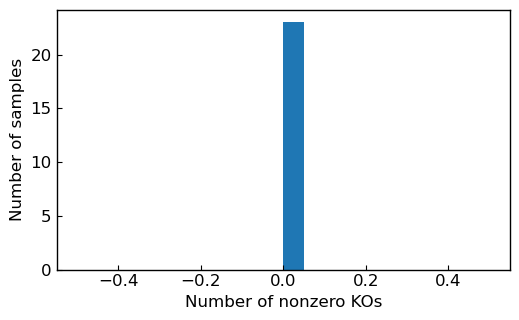

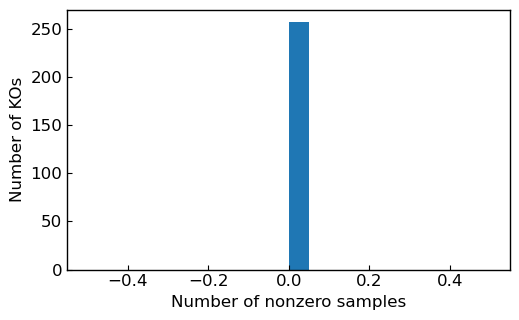

Chrysochromulina sp. KB-HA01
0 contigs


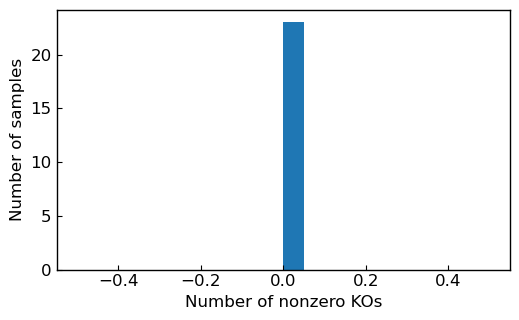

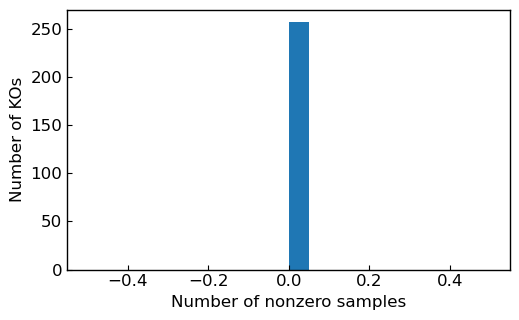

In [141]:
tid_pos = '35677' # Pelagomonas calceolata
tid_neg = '2802065' # Chrysochromulina sp. KB-HA01


for tid in [tid_pos, tid_neg]:
    print(ncbi.get_taxid_translator([tid])[int(tid)])
    contigs = dict_tax_contigs[tid]
    print(len(contigs), 'contigs')
    dict_ko_estcounts = {}
    for c in contigs:
        ko = dict_contig_ko[c]
        estcounts = dict_contig_estcounts[c]
        estcounts = np.array(estcounts)
        if ko in dict_ko_estcounts:
            dict_ko_estcounts[ko] += estcounts
        else:
            dict_ko_estcounts[ko] = estcounts
    estc_list = []
    for ko in kos_all:
        if ko in dict_ko_estcounts:
            estc_list.append(dict_ko_estcounts[ko])
        else:
            estc_list.append(np.zeros(nsam))
    estc_arr = np.array(estc_list)

    estc_bool = estc_arr.astype(bool)
    ax1_sum = estc_bool.sum(axis=1)
    ax0_sum = estc_bool.sum(axis=0)

    fig, ax = general_plot()
    _ = ax.hist(ax0_sum, bins=20)
    _ = ax.set_xlabel('Number of nonzero KOs')
    _ = ax.set_ylabel('Number of samples')
    plt.show()

    fig, ax = general_plot()
    _ = ax.hist(ax1_sum, bins=20)
    _ = ax.set_xlabel('Number of nonzero samples')
    _ = ax.set_ylabel('Number of KOs')
    plt.show()



In [ ]:
True + True

In [ ]:
len(next(iter(dict_contig_estcounts.values())))

In [799]:
a = defaultdict(lambda: np.zeros(3))

In [800]:
a['a'] += np.ones(3)

In [49]:
dictofdicts = defaultdict(dict)
for contig, tax in dict_contig_tax.items():
    ko = dict_contig_ko[contig]
    estcounts = dict_contig_estcounts[contig]
    dictofdicts[contig]['tax'] = tax
    dictofdicts[contig]['ko'] = ko
    dictofdicts[contig]['estcounts'] = estcounts


In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
_13.iloc[0,:]

In [ ]:
next(iter(dict_contig_tax))

In [ ]:
dict_contig_tax['G1PA_S02C1_0_2um_TRINITY_DN1001023_c0_g1_i1_2']

In [ ]:
test.ncbi.get_name_translator('Pelagomonas')

In [ ]:
a = pd.DataFrame({'a':[1,'',3],'b':[4,5,6]})
b = a.loc[a.a == 2].squeeze()
b.a

In [55]:
del TreeTrim

In [ ]:
fn_tidy = 'tidytest.csv'
# fn_tidy = 'metat_search_results/dicts_iron_KO_contig/tidy_tables/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tidys/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tidy.csv'

os.path.exists(fn_tidy)

True

In [98]:
del t
gc.collect()


214955

In [147]:
from scripts.cl_tree_trim_02 import TreeTrim

t = TreeTrim(fn_tidy)

Loading dicts...
Current memory usage: 5436.50 MB
Time to load dicts: 0.0 min 41.24373960494995 sec
Current memory usage: 6814.00 MB


In [152]:
t.trim_tree(
    filt_func_name='nkos_in_gt_minsamples',
    thresh=30,
    minsamples=4
)

37328 trimmed...with 1 contigs and 1 kos
1206737 trimmed...with 1 contigs and 1 kos
1160137 trimmed...with 1 contigs and 1 kos
1817 trimmed...with 6 contigs and 4 kos
1443890 trimmed...with 1 contigs and 1 kos
101510 trimmed...with 1 contigs and 1 kos
85025 trimmed...with 8 contigs and 5 kos
36809 trimmed...with 1 contigs and 1 kos
1078020 trimmed...with 1 contigs and 1 kos
1762 trimmed...with 3 contigs and 2 kos
858619 trimmed...with 1 contigs and 1 kos
1223543 trimmed...with 1 contigs and 1 kos
85007 trimmed...with 14 contigs and 8 kos
440482 trimmed...with 1 contigs and 1 kos
399736 trimmed...with 1 contigs and 1 kos
1385519 trimmed...with 1 contigs and 1 kos
85006 trimmed...with 3 contigs and 2 kos
182640 trimmed...with 1 contigs and 1 kos
396389 trimmed...with 1 contigs and 1 kos
85009 trimmed...with 2 contigs and 2 kos
2020 trimmed...with 1 contigs and 1 kos
570268 trimmed...with 2 contigs and 1 kos
85012 trimmed...with 3 contigs and 2 kos
1415549 trimmed...with 1 contigs and 1 k

In [149]:
print(t.tree.to_str(props=['sci_name', 'name'], compact=True))

                                                                                                                                                                               ╭╴Nocardia carnea,37328
                                                                                                                                                               ╭╴Nocardia,1817╶┼╴Nocardia pneumoniae NBRC 100136,1206737
                                                                                                                                          ╭╴Nocardiaceae,85025╶┤               ╰╴Nocardia sp. BMG111209,1160137
                                                                                                                                          │                    ├╴Rhodococcoides fascians 04-516,1443890
                                                                                                                                          │                    ╰╴Rhodococcus jos

In [150]:
print(t.treetrim.to_str(props=['sci_name', 'name'], compact=True))

                           ╭╴Bacteria,2╶╌╴Pseudomonadota,1224
                           │                                                                        ╭╴Protostomia,33317╶┬╴Lophotrochozoa,1206795
                           │                                                      ╭╴Bilateria,33213╶┤                   ╰╴Neocopepoda,116569╶┬╴Podoplea,116571╶╌╴Paracyclopina nana,565004
                           │                                     ╭╴Eumetazoa,6072╶┤                 │                                        ╰╴Calanoida,6833╶╌╴Calanidae,6835╶╌╴Calanus finmarchicus,6837
                           │                ╭╴Opisthokonta,33154╶┤                │                 ╰╴Oikopleura dioica,34765
                           │                │                    │                ╰╴Cnidaria,6073
                           │                │                    ╰╴unclassified Acanthoeca,2618734
                           │                │                                   

In [108]:
contigs = t.dict_taxtrim_contigs['226']  # Alteromonas
dict_ko_sam_estcounts = defaultdict(lambda: 
    defaultdict(float)
)
for c in contigs:
    ko = t.dict_contig[t.col_ko][c]
    sams = t.dict_contig[t.col_sample][c]
    estcounts = t.dict_contig[t.col_estcounts][c]
    for s, ec in zip(sams, estcounts):
        dict_ko_sam_estcounts[ko][s] += float(ec)

len(dict_ko_sam_estcounts), next(iter(dict_ko_sam_estcounts.keys()))

(65, 'K00134')

In [116]:
nkos = 0
kos = []
for ko, dict_sam_estcounts in dict_ko_sam_estcounts.items():
    ko_in_nsam = 0
    for _, ec in dict_sam_estcounts.items():
        ko_in_nsam += bool(ec)
    if ko_in_nsam >= 4:
        nkos += 1
        kos.append(ko)
len(kos), nkos

(58, 58)

In [117]:
dict_ko_sam_estcounts[kos[0]]

defaultdict(float,
            {'G5.RR2.cont.T24.A.tsv': 108.04509999999999,
             'G5.RR1.NPSiFe.T24.B.tsv': 0.0,
             'G5.RR1.NPSi.T24.C.tsv': 0.0,
             'G5.RR2.cont.T0.C.tsv': 25.957659999999997,
             'G5.RR2.Fe.T24.C.tsv': 42.40392,
             'G5.RR1.NP.T24.A.tsv': 0.0,
             'G5.RR2.NPSi.T24.B.tsv': 254.74314999999999,
             'G5.RR2.NPSiFe.T24.B.tsv': 497.13412000000005,
             'G5.RR1.cont.T24.C.tsv': 0.0,
             'G5.RR2.cont.T24.B.tsv': 231.88965,
             'G5.RR1.NPSiFe.T24.A.tsv': 1.0,
             'G5.RR2.NPSiFe.T24.A.tsv': 293.88901000000004,
             'G5.RR1.NP.T24.B.tsv': 0.0,
             'G5.RR2.NPSi.T24.A.tsv': 81.2798,
             'G5.RR2.cont.T0.B.tsv': 1.0,
             'G5.RR2.Fe.T24.B.tsv': 240.59587,
             'G5.RR2.NPSi.T24.C.tsv': 368.1857,
             'G5.RR2.NPSiFe.T24.C.tsv': 143.3511,
             'G5.RR1.NPSiFe.T24.C.tsv': 1.0,
             'G5.RR1.cont.T0.B.tsv': 0.0,
             '

Look at distribution of kos in two examples

Pelagomonas calceolata
7283 contigs


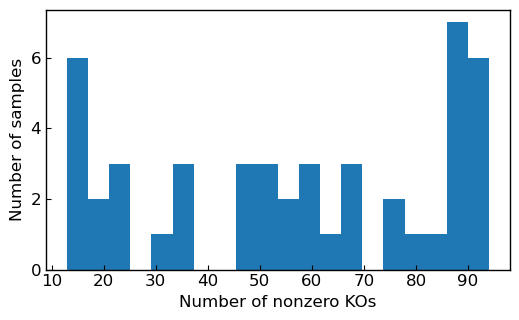

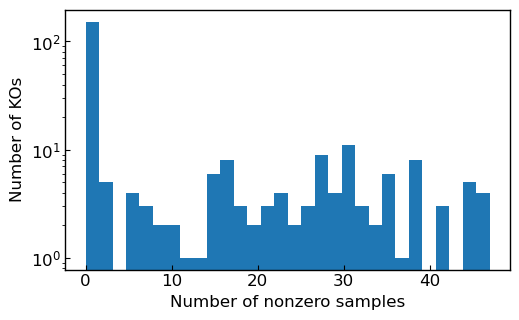

Isochrysidaceae
8 contigs


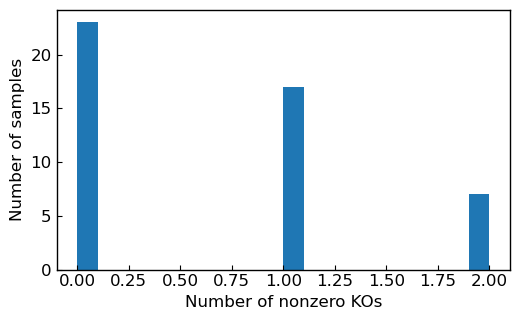

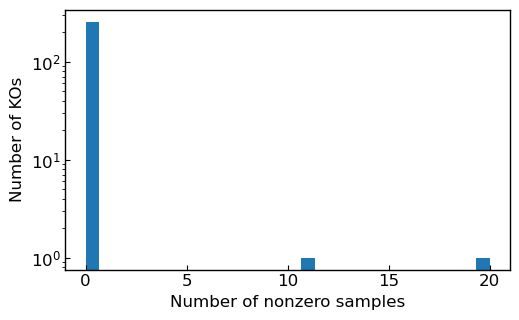

Mamiellophyceae
56 contigs


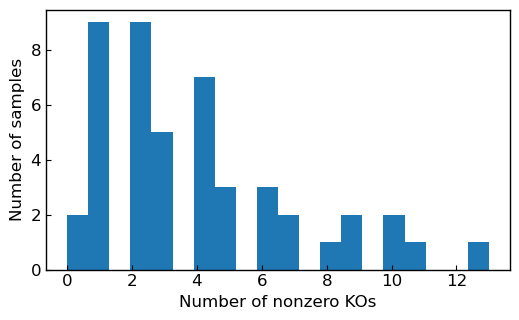

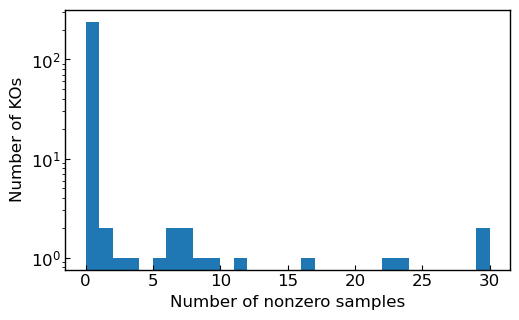

In [161]:
tid_pos = '35677' # Pelagomonas calceolata
tid_neg = '418951' # Isochrysidaceae
tid_neg2 = '1035538' # mamiellophyceae

tids = [tid_pos, tid_neg, tid_neg2]


kos_all = set(list(t.dict_contig[t.col_ko].values()))
sams_all = set([s for ss in t.dict_contig[t.col_sample].values() for s in ss])
for tid in tids:
    print(ncbi.get_taxid_translator([tid])[int(tid)])
    contigs = t.dict_taxon_contigs[tid]
    print(len(contigs), 'contigs')
    dict_ko_sam_estcounts = defaultdict(lambda: defaultdict(float))
    for c in contigs:
        ko = t.dict_contig[t.col_ko][c]
        estcounts = t.dict_contig[t.col_estcounts][c]
        sams = t.dict_contig[t.col_sample][c]
        for ec, s in zip(estcounts, sams):
            dict_ko_sam_estcounts[ko][s] += float(ec)
    ec_ko_list = []
    for ko in kos_all:
        if ko in dict_ko_sam_estcounts:
            ec_sam_list = []
            for s in sams_all:
                ec_sam_list.append(dict_ko_sam_estcounts[ko].get(s,0))
            ec_ko_list.append(np.array(ec_sam_list))
        else:
            ec_ko_list.append(np.zeros(len(sams_all)))
    estc_arr = np.array(ec_ko_list)

    estc_bool = estc_arr.astype(bool)
    ax1_sum = estc_bool.sum(axis=1)
    ax0_sum = estc_bool.sum(axis=0)

    fig, ax = general_plot()
    _ = ax.hist(ax0_sum, bins=20)
    _ = ax.set_xlabel('Number of nonzero KOs')
    _ = ax.set_ylabel('Number of samples')
    plt.show()

    fig, ax = general_plot()
    _ = ax.hist(ax1_sum, bins=30)
    _ = ax.set_xlabel('Number of nonzero samples')
    _ = ax.set_ylabel('Number of KOs')
    _ = ax.set_yscale('log')
    plt.show()



In [11]:
import functions.fn_metat_files as fnf

In [41]:
fn = fn_tidy
col_key = 'contig'
cols_val = ['KO', 'taxon', 'estcounts', 'sample']
cols_key2list = ['estcounts', 'sample']
cols_key2value = ['KO','taxon']

In [44]:
import csv
import itertools

fnf.getmem()
with open(fn, 'r') as f:
    csv_reader = csv.DictReader(f)
    dict_out = defaultdict(lambda: defaultdict(list))
    for dict_row in csv_reader:
        key = dict_row[col_key]
        for cv in cols_key2list:
            dict_out[key][cv].append(dict_row[cv])
        for cv in cols_key2value:
            if not cv in dict_out[key]:
                dict_out[key][cv] = dict_row[cv]

    fnf.getmem()


Current memory usage: 799.50 MB
Current memory usage: 1643.50 MB


In [45]:
dict_out['G1PA_S02C1_0_2um_TRINITY_DN1020701_c0_g1_i1_3']

defaultdict(list,
            {'estcounts': ['0',
              '4',
              '0',
              '3',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '5',
              '5',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '12',
              '0',
              '0',
              '0',
              '0',
              '11',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '5',
              '0',
              '5',
              '0'],
             'sample': ['S08C1',
              'S14C1',
              'S0

In [43]:
del dict_out
gc.collect()
fnf.getmem()

Current memory usage: 799.50 MB


In [32]:
fnf.getmem()
with open(fn, 'r') as f:
    csv_reader = csv.DictReader(f)
    dict_out = defaultdict(list)
    for dict_row in csv_reader:
        key = dict_row[col_key]
        if not key in dict_out:
            for cv in cols_key2value:
                dict_out[key].append(dict_row[cv])
        for cv in cols_key2list:
            dict_out[key].append(dict_row[cv])

    fnf.getmem()

Current memory usage: 753.70 MB
Current memory usage: 1574.14 MB


In [53]:
del dict_out
gc.collect()
fnf.getmem()

Current memory usage: 2435.11 MB


In [54]:
fnf.getmem()

cols_key2list = ['estcounts', 'sample']
cols_key2value = ['KO','taxon']
dicts_out_val = [{} for _ in cols_key2value]
dicts_out_list = [defaultdict(list) for _ in cols_key2list]

with open(fn, 'r') as f:
    csv_reader = csv.DictReader(f)
    for dict_row in csv_reader:
        k = dict_row[col_key]
        for i, v in enumerate(cols_key2value):
            dicts_out_val[i][k] = dict_row[v]
        for i, v in enumerate(cols_key2list):
            dicts_out_list[i][k].append(dict_row[v])

fnf.getmem()


Current memory usage: 2435.11 MB
Current memory usage: 3168.67 MB


In [55]:
dicts_out_val[0]['G1PA_S02C1_0_2um_TRINITY_DN1020701_c0_g1_i1_3']

'K00134'

In [52]:
del dicts_out_list, dicts_out_val
gc.collect()
fnf.getmem()

Current memory usage: 3231.04 MB


In [23]:
next(iter(dict_out.keys()))

'G1PA_S02C1_0_2um_TRINITY_DN1020701_c0_g1_i1_3'

In [29]:
not 'G1PA_S02C1_0_2um_TRINITY_DN1020701_c0_g1_i1_3' in dict_out

False

In [24]:
dict_out['G1PA_S02C1_0_2um_TRINITY_DN1020701_c0_g1_i1_3']

defaultdict(list,
            {'estcounts': ['0',
              '4',
              '0',
              '3',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '5',
              '5',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '12',
              '0',
              '0',
              '0',
              '0',
              '11',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '0',
              '5',
              '0',
              '5',
              '0']})

In [15]:
fnf.getmem()
dict_contig = fnf.tidytable_to_dict(fn, col_key, cols_val)
fnf.getmem()


Current memory usage: 704.36 MB
Current memory usage: 5301.89 MB


In [16]:
sys.getsizeof(dict_contig)

10485864

In [31]:
sys.getsizeof(dict_out)

5242976

In [38]:
sys.getsizeof(dict_out)

5242976

In [32]:
with open(fn, 'r') as f:
    csv_reader = csv.reader(f)
    print(next(csv_reader, None))
    for row in csv_reader:
        print(row)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [29]:
gc.isenabled()

True

In [25]:
sys.getsizeof() / 1e6

2.4e-05

In [ ]:
dict_contig['G3PA.UW1_TRINITY_DN1000146_c1_g1_i1_1']['KO'][0]

In [101]:
dict_contig_taxon = {}
dict_contig_ko = {}
dict_contig_estcounts = {}
dict_contig_samples = {}
for c, d in dict_contig.items():
    dict_contig_taxon[c] = d['taxon'][0]
    dict_contig_ko[c] = d['KO'][0]
    dict_contig_estcounts[c] = d['estcounts']
    dict_contig_samples[c] = d['sample']

In [ ]:
dict_contig_taxon['G3PA.UW1_TRINITY_DN1000146_c1_g1_i1_1']

In [20]:
notempty = 0
empty = 0
for c, ec in t.dict_contig_estcounts.items():
    ec = [float(i) for i in ec]
    if sum(ec) > 0:
        notempty += 1
    else:
        empty += 1

In [22]:
notempty, empty

(307668, 38266)

In [23]:
fnf.getmem()


Current memory usage: 5141.08 MB
